## University Ranking Predictions

In [399]:
%matplotlib inline
import pandas as pd
import numpy as np
shanghai_data_full = pd.read_csv("data/shanghaiData.csv")
shanghai_data_full = shanghai_data_full[shanghai_data_full.total_score.notnull()]
#shanghai_data_full.head()

## Split to Training and Test

In [400]:
names_full = shanghai_data_full['university_name'][0:100]
rows = np.random.choice(names_full.index.values, 20)
names_test = names_full.ix[rows]
names = names_full.drop(rows)

In [401]:
shanghai_data_test = shanghai_data_full[shanghai_data_full.university_name.isin(names_test)]
shanghai_data = shanghai_data_full[shanghai_data_full.university_name.isin(names)]

features_with_name = ['total_score', 'university_name', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp', 'year']
prediction_data_test = shanghai_data_test.loc[:,features_with_name]
prediction_data = shanghai_data.loc[:,features_with_name]
prediction_data.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year
0,100.0,Harvard University,1,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,73.6,University of Cambridge,1,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,73.4,Stanford University,2,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,72.8,"University of California, Berkeley",3,71.8,76.0,69.4,73.9,72.2,52.7,2005
5,67.1,California Institute of Technology,5,59.2,68.6,59.8,65.8,52.5,100.0,2005


## Using Multiple Past Years

In [404]:
years_back = 4
to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp']
def add_old_as_features(dataset):
    for index, row in dataset.iterrows():
        is_complete = True
        past_rows = {}
        #past_rows[0] = dataset[(dataset.university_name == row.university_name) & (dataset.year == row.year)]
        for year in range(0, years_back+1):
            past_row = dataset[(dataset.university_name == row.university_name) & (dataset.year == row.year-year)]
            past_rows[year] = past_row
            if len(past_row.values) == 0:
                is_complete = False

        if (is_complete):
            past_row = past_rows[1]
            current_row = past_rows[0]
            # TODO reverse loop structure to reduce complexity, possibly combine with above
            for feature in to_predict:
                # Sketchy ass feature scaling
                dataset.loc[index, feature + '_last'] = float(past_row[feature].values[0])/30
                # This will be our y, predict the delta instead of absolute value
                dataset.loc[index, feature + '_change'] = (float(current_row[feature].values[0]) - float(past_row[feature].values[0]))
                
            for year in range(1, years_back):
                past_row = past_rows[year + 1]
                current_row = past_rows[year]
                for feature in to_predict:
                    dataset.loc[index, feature + '_back_' + str(year)] = (float(current_row[feature].values[0]) - float(past_row[feature].values[0]))

    complete_filter = dataset.apply(lambda row : np.isnan(row['total_score_back_' + str(years_back - 1)]),axis=1) 
    return dataset[~complete_filter]

prediction_data_clean = add_old_as_features(prediction_data.copy())
prediction_data_test_clean = add_old_as_features(prediction_data_test.copy())
prediction_data_clean.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year,...,pub_back_2,pcp_back_2,total_score_back_3,national_rank_back_3,alumni_back_3,award_back_3,hici_back_3,ns_back_3,pub_back_3,pcp_back_3
2013,100.0,Harvard University,1,100.0,100.0,100.0,100.0,100.0,74.8,2009,...,0.0,-0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
2014,73.1,Stanford University,2,39.0,78.7,87.1,67.3,70.1,66.9,2009,...,-1.1,0.4,-0.9,0.0,-1.4,-1.5,-0.1,-0.9,-0.9,0.3
2015,71.0,"University of California, Berkeley",3,67.4,77.1,68.4,71.1,69.0,53.2,2009,...,-2.7,-0.5,-0.7,0.0,-1.2,-1.5,1.1,-1.7,-0.3,0.4
2016,70.2,University of Cambridge,1,89.4,91.5,53.8,53.9,65.4,65.5,2009,...,-1.7,-1.4,-1.0,0.0,-3.5,-1.9,0.5,2.9,-3.8,-0.4
2018,64.8,California Institute of Technology,5,51.5,69.1,57.1,66.2,47.7,100.0,2009,...,0.2,0.0,-1.1,0.0,-2.1,0.5,-0.7,-1.3,-2.4,0.0


In [405]:
features = []
for feature in to_predict:
    features.append(feature + '_last')
    for year in range(1, years_back):
        features.append(feature + '_back_' + str(year))
X = prediction_data_clean.loc[:,features]
X.head()

,total_score_last,total_score_back_1,total_score_back_2,total_score_back_3,national_rank_last,national_rank_back_1,national_rank_back_2,national_rank_back_3,alumni_last,alumni_back_1,...,hici_back_2,hici_back_3,pub_last,pub_back_1,pub_back_2,pub_back_3,pcp_last,pcp_back_1,pcp_back_2,pcp_back_3
2013,3.333333,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,3.333333,0.0,...,0.0,0.0,3.333333,0.0,0.0,0.0,2.470000,1.1,-0.6,1.2
2014,2.456667,0.0,1.2,-0.9,0.066667,0.0,0.0,0.0,1.333333,-2.0,...,-2.3,-0.1,2.386667,1.3,-1.1,-0.9,2.230000,1.2,0.4,0.3
2015,2.380000,-0.5,-0.2,-0.7,0.100000,0.0,0.0,0.0,2.300000,-3.5,...,-2.6,1.1,2.333333,0.8,-2.7,-0.3,1.766667,0.4,-0.5,0.4
2016,2.346667,-1.2,-1.0,-1.0,0.033333,0.0,0.0,0.0,3.010000,-3.3,...,0.2,0.5,2.136667,-1.3,-1.7,-3.8,2.166667,-0.1,-1.4,-0.4
2018,2.180000,-1.0,0.4,-1.1,0.166667,0.0,0.0,0.0,1.760000,-2.7,...,-0.7,-0.7,1.656667,-0.6,0.2,-2.4,3.333333,0.0,0.0,0.0


## Scaling Features

In [406]:
from sklearn.preprocessing import StandardScaler

# TODO do something...


#scaler = StandardScaler()
#scaler.fit()
#prediction_data.loc[:,to_predict] = scaler.transform(prediction_data.loc[:,to_predict])
#prediction_data_test.loc[:,to_predict] = scaler.transform(prediction_data_test.loc[:,to_predict])
#prediction_data.head()

## Dont Modify `prediction_data_clean` From Here 

In [407]:
X = prediction_data_clean.loc[:,features]

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
clf_map = {}
# Just going to use Linear for now to save time
# Don't know how to split training set properly here to save test set
# Can we score ourself with a few iterations down the line?
for feature in to_predict:
    clf = LinearRegression()
    y = np.ravel(prediction_data_clean.loc[:,[feature + '_change']])
    clf.fit(X, y)
    clf_map[feature] = clf
    cv_scores = cross_val_score(clf, X, y, cv=3)
    print (cv_scores)

[-0.0525849  -0.27383254 -0.1475129 ]
[-0.14765497 -0.48955861 -0.12835749]
[-0.0779156  -0.34348124 -1.63675789]
[-0.22795298  0.00281961 -0.04866174]
[-1.19831261 -1.94640067 -0.15987226]
[-0.49184415 -0.33243116 -0.15108164]
[-1.19831261 -1.94640067 -0.15987226]
[-0.12486238 -0.09570041 -0.37250152]
[-0.03620982 -0.46522537 -3.74597551]


## Make Prediction Code Reuseable

In [408]:
import seaborn as sb
import matplotlib.pyplot as plt

In [409]:
def get_school_graph_data(school_name_to_predict):
    university_data = prediction_data_next[(prediction_data_next.university_name == school_name_to_predict) & (prediction_data_next.year == (2005 + years_back))]
    X = university_data.loc[:,features]
    start_scores = X['total_score_back_' + str(years_back)].values
    for i in range(1, years_back):
        start_scores = np.append(start_scores, X['total_score_back_' + str(years_back-i)].values)

    real_scores = prediction_data_next[prediction_data_next.university_name == school_name_to_predict]['total_score'].values
    real_scores = np.append(start_scores, real_scores)
    
    predicted_scores = start_scores.copy()
    X_continue = X.copy()
    for i in range(len(real_scores) - years_back):
        X_original = X_continue.copy()
        for feature in to_predict:
            X_continue[feature + '_back_1'] = clf_map[feature].predict(X_original)
            for i in range(1, years_back):
                X_continue[feature + '_back_' + str(i + 1)] = X_original[feature + '_back_' + str(i)]
        predicted_scores = np.append(predicted_scores, X_continue['total_score_back_1'].values)

    end_year = 2005 + len(real_scores)
    years = np.array(range(2005, end_year))
    predicted = pd.DataFrame({ 'score' : predicted_scores, 'year' : years })
    real = pd.DataFrame({ 'score' : real_scores, 'year' : years })
    predicted['kind'] = school_name_to_predict + ' Predicted'
    real['kind'] = school_name_to_predict + ' Real'
    graph_data = predicted.append(real)
    return graph_data

prediction_data_next = prediction_data_clean.copy()
school_name_to_predict = ['University of California, Berkeley']
graph_data = get_school_graph_data(school_name_to_predict[0])
graph = sb.pointplot(x='year', y='score', hue='kind', data=graph_data)

KeyError: 'total_score_back_4'

In [251]:
def plot_scores_by_names(universities_to_plot):
    graph_data = pd.DataFrame()
    num_universitites = len(universities_to_plot)
    linestyles = ["-", "--"]*num_universitites
    markers= ["o", "x"]*num_universitites
    palette = np.repeat(sb.color_palette("Set1", n_colors=num_universitites, desat=.5), 2, axis=0)

    for name in universities_to_plot:
        graph_data = graph_data.append(get_school_graph_data(name))
    fig, (ax) = plt.subplots(1,1, figsize=(20,10))
    sb.pointplot(x='year', y='score', hue='kind', linestyles=linestyles, markers=markers, palette=palette, data=graph_data, ax=ax)

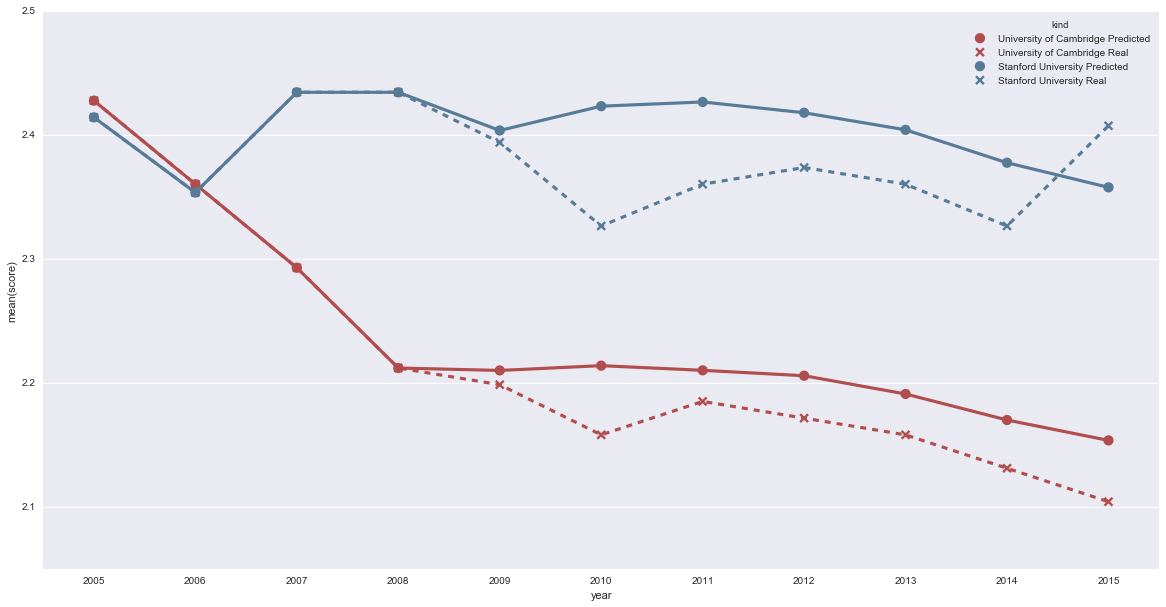

In [252]:
plot_scores_by_names(shanghai_data[1:3]['university_name'].values)

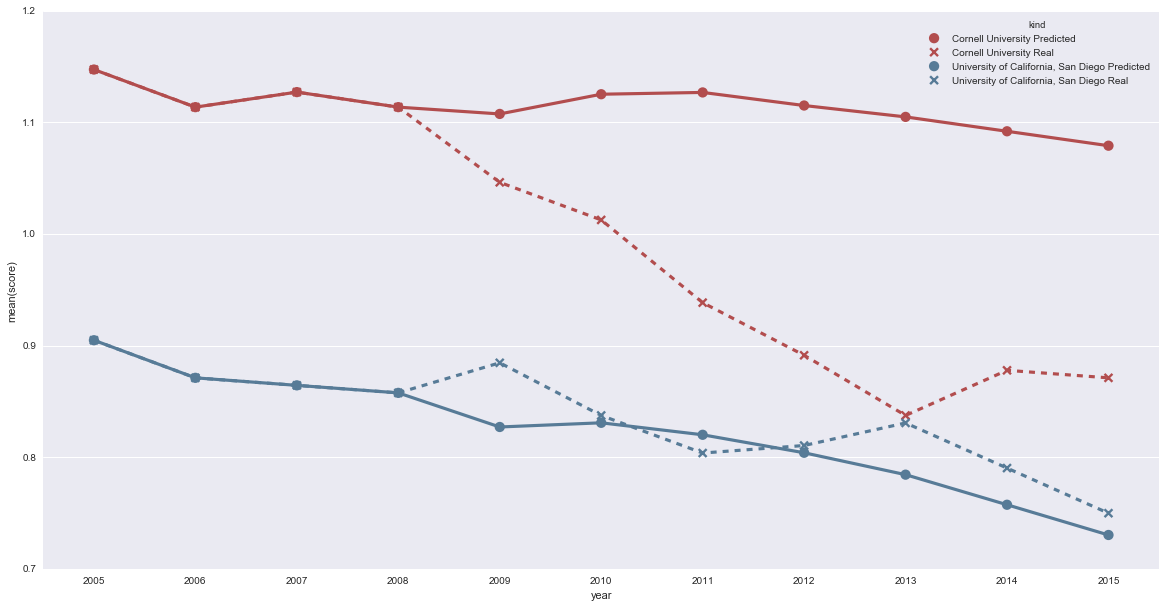

In [253]:
plot_scores_by_names(shanghai_data[11:13]['university_name'].values)

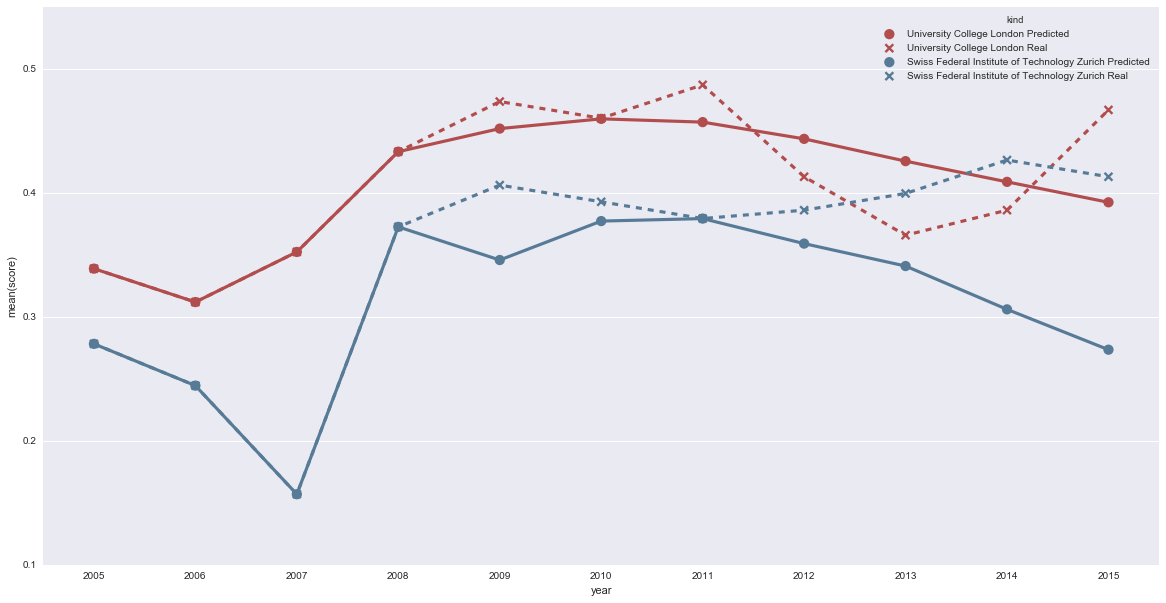

In [254]:
plot_scores_by_names(shanghai_data[21:23]['university_name'].values)

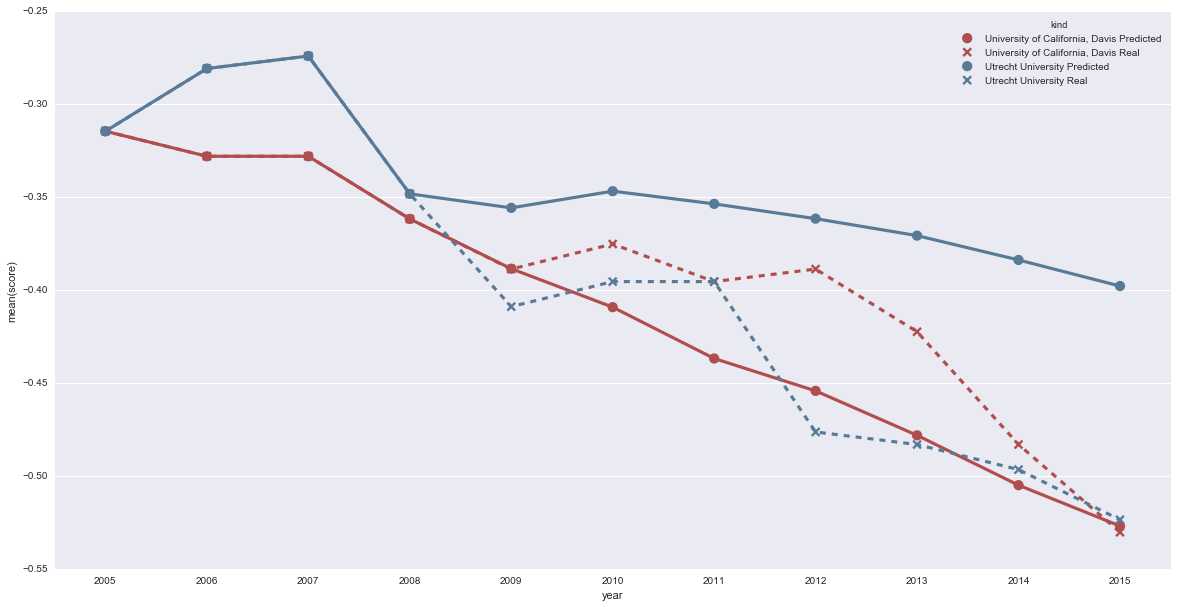

In [255]:
plot_scores_by_names(shanghai_data[31:33]['university_name'].values)

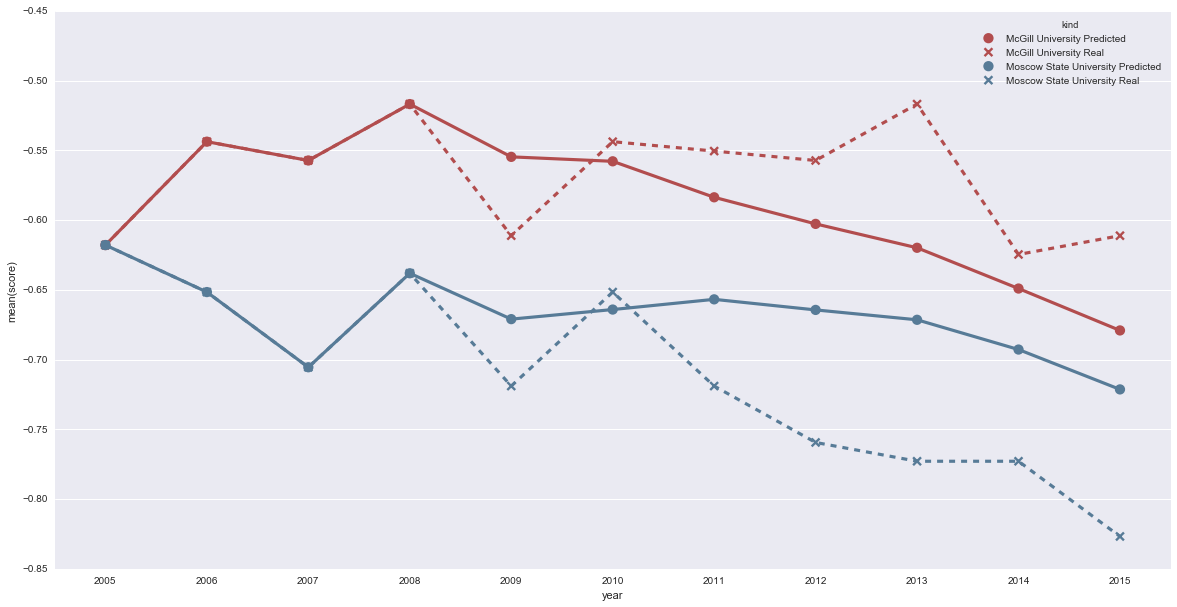

In [256]:
plot_scores_by_names(shanghai_data[51:53]['university_name'].values)